In [1]:
import sys
import os

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Parent directory
sys.path.append(base_path)
file_path = os.path.join(base_path, "data/boston/bike_trip_focused_data.parquet")


In [2]:
import os
import numpy as np
import pickle as pkl 
import time
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import shap
import DIFFI.interpretability_module as interp
from DIFFI.utils import *

from src import data_processing as dp
from datetime import datetime


/Users/elnur/Desktop/Master_thesis/anomaly_detection_for_shared_mobility/adbike_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
station_data = dp.from_trip_to_station_focused(file_path)

In [4]:
features = [
    'count',                 # Core usage metric
    'distance_mean',         # Average trip distance
    'tripduration_mean',     # Average trip duration
    'speed_mean',            # Average trip speed
    'temp_mean',             # Weather impact
    'prcp_mean',             # Weather impact
    'wspd_mean',             # Weather impact
    'hour',                  # Temporal variation
    'day',
    'dayofweek',             # Temporal variation
    'nearby_transit_stops',   # Station context
    'user_type_encoded_mean',
    'coco_mean',             
    'is_weekend',
    'neighborhood',
    'is_start'
]
X = station_data[features].fillna(0)


In [5]:
iforest = IsolationForest(n_estimators= 500, max_samples=1024, contamination='auto', random_state=0)
iforest.fit(X)
y_pred = np.array(iforest.decision_function(X) < 0).astype('int')


In [6]:
sorted_idx = diffi_ranks(X, n_trees=100, max_samples=1024, n_iter=5)
sorted_feature_names = X.columns[sorted_idx].tolist()

In [7]:
# Local-DIFFI
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(iforest, X.iloc[y_pred == 1][:100])
print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_te),3)))

Average computational time Local-DIFFI: 0.305


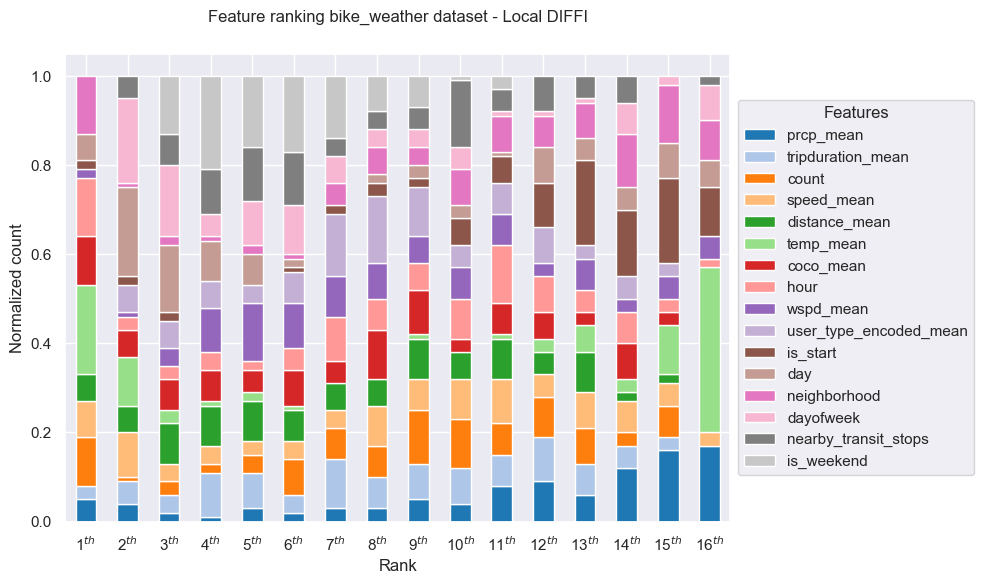

In [8]:
plot_feature_ranking(ord_idx_diffi_te, title = 'Feature ranking bike_weather dataset - Local DIFFI', sorted_feature_names = sorted_feature_names)